# Video Surveillance for Road Traffic Monitoring
## _Week 1: Background estimation_
***

In [37]:
import numpy as np
import cv2
import pickle

print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

# Newer versions of OpenCV and NumPy won't work with MOG and LSBP (Task 3)

NumPy version: 2.2.3
OpenCV version: 4.11.0


In [2]:
from src.task3 import remove_background_opencv
from src.postprocess import *
from src.metrics import *

In [3]:
# Path to the video file
vid_path = 'data/AICity_data/AICity_data/train/S03/c010/vdo.avi'

In [40]:
# Load ground truth annotations as a list of lists
from src.metrics import parse_gt_annotations
gt_list = parse_gt_annotations('data/ai_challenge_s03_c010-full_annotation.xml')

# Save to a pickle file
with open('gt_annotations.pkl', 'wb') as f:
    pickle.dump(gt_list, f)

In [ ]:
# Generate video of the ground truth bounding boxes
generate_bounding_box_video(gt_list, vid_path, 'output/gt_bboxes.avi', (0, 0, 255))

## Task 1.1. Gaussian modelling
***

Create gif gaussian animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

def gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def plot_gaussian(sigma, alphas, color):
    mu = 0  # Media fija en 0
    x = np.linspace(-5 * sigma, 5 * sigma, 1000)
    y = gaussian(x, mu, sigma)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y)
    
    # Rellenar áreas con colores semitransparentes
    plt.fill_between(x, y, where=(x >= mu - alphas * sigma) & (x <= mu + alphas * sigma), 
                     color='blue', alpha=0.1, label='Background')
    plt.fill_between(x, y, where=(x < mu - alphas * sigma) | (x > mu + alphas * sigma), 
                     color='red', alpha=0.2, label='Foreground')
    
    # Agregar líneas verticales en μ - ασ y μ + ασ con colores personalizados
    plt.axvline(mu - alphas * sigma, color=color, linestyle='solid', label=f'α = {alphas}', linewidth=3)
    plt.axvline(mu + alphas * sigma, color=color, linestyle='solid', linewidth=3)
    plt.axvline(mu, color='lightgray', linestyle='dashed', linewidth=1)
        
    plt.text(mu - alphas * sigma - 0.5, max(y) * 0.65, rf'$\mu - {alphas} \cdot \sigma$', horizontalalignment='right', fontsize=16, color=color)
    plt.text(mu + alphas * sigma + 0.5, max(y) * 0.65, rf'$\mu + {alphas} \cdot \sigma$', horizontalalignment='left', fontsize=16, color=color)

    # Eliminar los bordes del gráfico
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Configuración del eje X
    plt.xticks([mu], ["μ"], fontsize=20)
    plt.yticks([])
    plt.legend(fontsize=17)
    
    # Guardar la imagen en un objeto BytesIO
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)
    return Image.open(buf)

def create_gif(sigma, alphas, filename='gaussian_animation.gif', duration=1500):
    # Generar colores verdes de claro a oscuro
    colors = [plt.cm.Oranges(i / len(alphas)) for i in range(1, len(alphas) + 1)]
    
    frames = [plot_gaussian(sigma, alpha, color) for alpha, color in zip(alphas, colors)]
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)
    print(f'GIF guardado como {filename}')

# Crear el GIF con valores de α = 0.5, 1, 2, 3, 4
create_gif(sigma=1.0, alphas=[0.5, 1, 2, 3])

GIF guardado como gaussian_animation.gif


In [2]:
from PIL import Image

def masks_to_gif(mask_list, output_path="masks.gif", duration=100, loop=0):
    frames = [Image.fromarray(mask * 255) for mask in mask_list]  # Convert masks to grayscale images
    frames[0].save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=loop)
    print(f"GIF saved at {output_path}")

In [ ]:
from src.task2 import GMMDetector
import cv2

detector = GMMDetector(
    video_path = 'data/AICity_data/train/S03/c010/vdo.avi',
    image_reduction=8,
    color_space=cv2.COLOR_BGR2Lab,
    mask_cleaning='OPENING',
    mask_enhancing='CLOSING'
)
detector.train()
detector.test(alpha=6, rho=0.001, area_threshold=35)

Classifying test frames: 21it [00:00, 54.82it/s]


KeyboardInterrupt: 

In [30]:
masks = detector.masks[:999] # Original one
#masks = [detector._clean_mask(mask) for mask in detector.masks[:999]] # Cleaned one
#masks = [detector._enhance_mask(detector._clean_mask(mask)) for mask in detector.masks[:999]] # Enhanced one
masks_to_gif(masks, output_path="./outputs/large_alpha.gif", duration=20, loop=0)

GIF saved at ./outputs/large_alpha.gif


In [50]:
import numpy as np

def frames_with_bboxes_to_gif(frames_list, predictions, output_path="output.gif", ground_truth=None, duration=100, loop=0):
    frames = []

    for frame_idx, frame in enumerate(frames_list):
        # Convert mask to grayscale image
        # frame = (frame * 255).astype(np.uint8) # if mask
        if frame.ndim == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel for color overlays

        # Draw predicted bounding boxes (red)
        if frame_idx < len(predictions):
            for bbox in predictions[frame_idx]:
                x1, y1, x2, y2 = bbox
                cv2.rectangle(frame, (x1//4, y1//4), (x2//4, y2//4), (0, 0, 255), 1)

        # Draw ground truth bounding boxes (green)
        if ground_truth is not None and frame_idx < len(ground_truth):
            for bbox in ground_truth[frame_idx]:
                x1, y1, x2, y2 = bbox.astype(int)
                cv2.rectangle(frame, (x1//4, y1//4), (x2//4, y2//4), (0, 255, 0), 1)

        # Convert back to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Convert back to PIL Image and add to frames list
        frames.append(Image.fromarray(frame))

    # Save as GIF
    frames[0].save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=loop)
    print(f"GIF saved at {output_path}")

In [ ]:
frames_with_bboxes_to_gif(masks, detector.get_predictions()[:999], output_path='outputs/with_boxes.gif', ground_truth=None, duration=20)

GIF saved at outputs/with_boxes.gif


Plot mean and std images of the background

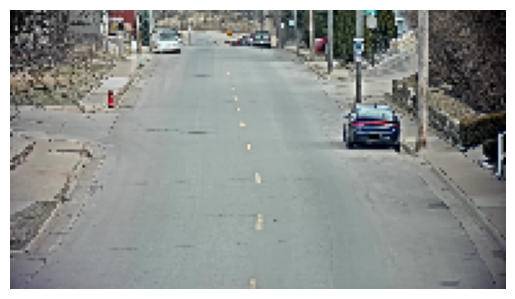

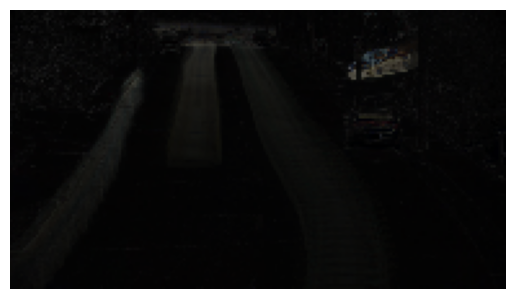

In [ ]:
from src.task1 import GaussianDetector
import cv2
import numpy as np
import matplotlib.pyplot as plt

detector = GaussianDetector(
    video_path = 'data/AICity_data/train/S03/c010/vdo.avi',
    image_reduction=2,
)

detector.train(method='mean')

mean = (detector.background_mean.astype(np.uint8))
mean_rgb = cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)

std = (detector.background_std.astype(np.uint8))
std_rgb = cv2.cvtColor(std, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.imshow(mean_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()

plt.imshow(std_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()

Plot median and std images of the background

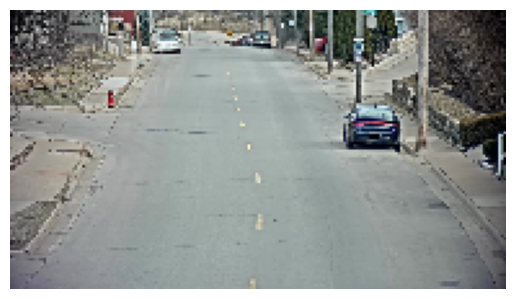

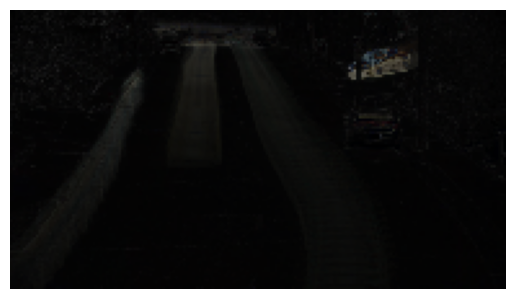

In [23]:
from src.task1 import GaussianDetector
import cv2
import numpy as np
import matplotlib.pyplot as plt

detector = GaussianDetector(
    video_path = 'data/AICity_data/train/S03/c010/vdo.avi',
    image_reduction=10,
)

detector.train(method='median')

mean = (detector.background_mean.astype(np.uint8))
mean_rgb = cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)

std = (detector.background_std.astype(np.uint8))
std_rgb = cv2.cvtColor(std, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.imshow(mean_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()

plt.imshow(std_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()

Create gif from video

In [ ]:
import imageio
from tqdm import tqdm

def create_gif_from_video(video_file, start_time, end_time, output_gif, downsample_factor=1):
    """
    Crea un GIF a partir de un vídeo .mp4 usando imageio y realiza un downsample.

    :param video_file: Ruta del archivo de vídeo .mp4
    :param start_time: Tiempo de inicio en segundos para el GIF
    :param end_time: Tiempo de fin en segundos para el GIF
    :param output_gif: Ruta del archivo de salida .gif
    :param downsample_factor: Factor de downsample (mayor que 1 para reducir la resolución)
    """
    # Leer el vídeo
    reader = imageio.get_reader(video_file)
    
    # Obtener el fotograma por segundo (fps)
    fps = reader.get_meta_data()['fps']

    # Crear el GIF
    writer = imageio.get_writer(output_gif, fps=fps)

    # Contar el total de fotogramas que se procesarán
    total_frames = int((end_time - start_time) * fps)

    # Proceso de creación del GIF con barra de progreso
    for i, frame in tqdm(enumerate(reader), total=total_frames, desc="Creando GIF"):
        # Convertir el tiempo actual en segundos
        current_time = i / fps
        if current_time < start_time:
            continue
        if current_time >= end_time:
            break
        
        # Hacer downsample del fotograma
        if downsample_factor > 1:
            frame = frame[::downsample_factor, ::downsample_factor]  # Reduce la resolución

        writer.append_data(frame)

    writer.close()

# Uso del script
video_file = '../bbox_adaptive.mp4'  # Cambia esto por el nombre de tu archivo
start_time = 10  # Tiempo de inicio en segundos
end_time = 15    # Tiempo de fin en segundos
output_gif = 'output.gif'  # Nombre del archivo GIF de salida
downsample_factor = 10  # Factor de downsample (2 para reducir a la mitad)

create_gif_from_video(video_file, start_time, end_time, output_gif, downsample_factor)

Creando GIF: 450it [00:01, 306.85it/s]                         


## Task 1.2. $\text{mAP}_{0.5}$ vs Alpha
***

In [51]:
frames_with_bboxes_to_gif(
    [cv2.cvtColor(frame, cv2.COLOR_Lab2BGR) for frame in detector.get_test_frames()][:999],
    detector.get_predictions()[:999],
    output_path='outputs/with_gt.gif',
    ground_truth=gt_list[detector.split_index:detector.split_index+999],
    duration=20
)

GIF saved at outputs/with_gt.gif


## RGB Colorspace

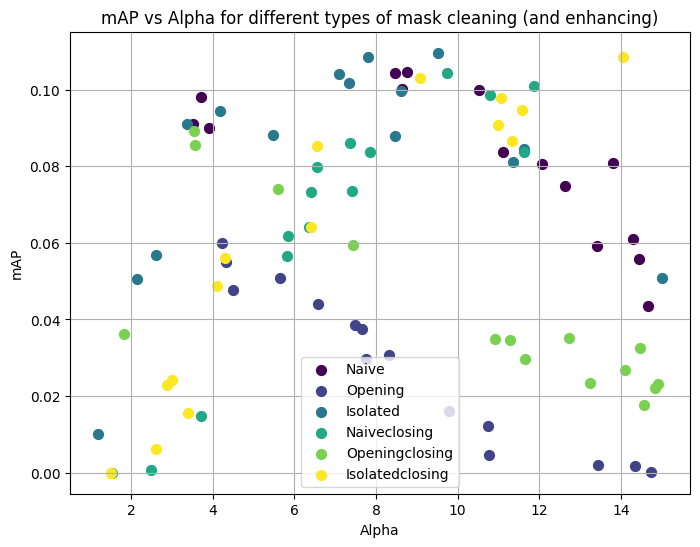

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_alpha_map(*file_paths):
    plt.figure(figsize=(8, 6))

    # Definir una lista de colores para diferenciar cada archivo
    colors = plt.cm.viridis(np.linspace(0, 1, len(file_paths)))

    for file_path, color in zip(file_paths, colors):
        alpha = []
        mAP = []

        with open(file_path, 'r') as f:
            next(f)  # Skip the first header line
            next(f)  # Skip the second header line

            # Read each line of the file and extract values
            for line in f:
                if line.strip():  # Ignore empty lines
                    parts = line.split()
                    alpha.append(float(parts[0]))
                    mAP.append(float(parts[1]))

        # Convert lists to numpy arrays for easier processing
        alpha = np.array(alpha)
        mAP = np.array(mAP)

        # Scatter plot for the current file
        label = file_path.split('_')[-1].replace('.txt', '').capitalize()
        plt.scatter(alpha, mAP, s=50, color=color, label=label)  

    # Labels, title, and legend
    plt.xlabel('Alpha')
    plt.ylabel('mAP')
    plt.title('mAP vs Alpha for different types of mask cleaning (and enhancing)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the function with multiple files
plot_alpha_map('../task1_results_naive.txt', '../task1_results_opening.txt', '../task1_results_isolated.txt',
               '../task1_results_naiveClosing.txt', '../task1_results_openingClosing.txt', '../task1_results_isolatedClosing.txt')


## Task 2.1. Adaptive modelling
***

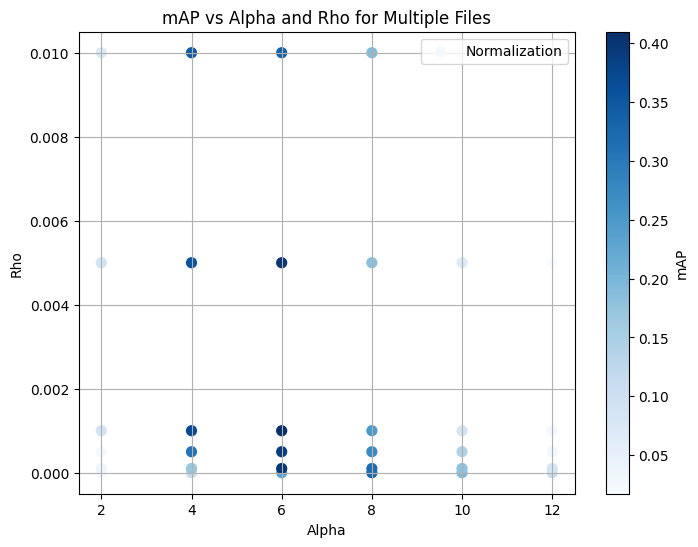

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(file_paths):
    # Define diferentes estilos de marcadores
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']  # Puedes añadir más si es necesario
    marker_count = len(markers)

    plt.figure(figsize=(8, 6))

    for i, file_path in enumerate(file_paths):
        alpha = []
        rho = []
        mAP = []

        with open(file_path, 'r') as f:
            # Skip headers
            next(f) 
            next(f)  

            # Read each line of the file and extract values
            for line in f:
                if line.strip():  # Ignore empty lines
                    parts = line.split()
                    alpha.append(float(parts[0]))
                    rho.append(float(parts[1]))
                    mAP.append(float(parts[2]))

        # Convert lists to numpy arrays for easier operations
        alpha = np.array(alpha)
        rho = np.array(rho)
        mAP = np.array(mAP)

        # Plot data with a different marker for each file
        label = file_path.split('_')[-1].replace('.txt', '').capitalize()
        scatter = plt.scatter(alpha, rho, c=mAP, cmap='Blues', s=50, 
                              marker=markers[i % marker_count], label=label)

    plt.colorbar(scatter, label='mAP')  # Add color bar
    plt.xlabel('Alpha')
    plt.ylabel('Rho')
    plt.title('mAP vs Alpha and Rho for Multiple Files')
    plt.grid(True)
    plt.legend()  # Show legend for different files
    plt.show()

# Llama a la función con una lista de archivos de resultados
plot_results(['results/task2_results_normalization.txt'])

## Task 2.2. Comparison of adaptive vs non-adaptive modelling
***

In [ ]:
# TODO

## Task 3. Comparison with state-of-the-art
***

[OpenCV Gaussian Mixture-based Background/Foreground Segmentation (I)](https://docs.opencv.org/3.4.0/d6/da7/classcv_1_1bgsegm_1_1BackgroundSubtractorMOG.html)

In [ ]:
# Remove background using MOG
remove_background_opencv(vid_path, "output/mask_output_MOG.avi", method="MOG")

# Denoise the mask
remove_noise("output/mask_output_MOG.avi", "output/mask_output_MOG_denoised.avi", kernel_size=3)

# Extract bounding boxes from the video
pred_bboxes_MOG = get_bounding_boxes("output/mask_output_MOG_denoised.avi")

# Apply NMS
pred_bboxes_MOG_nms = non_max_suppression(pred_bboxes_MOG)

# Save predictions in a pickle file
with open('pred_bboxes_MOG.pkl', 'wb') as f:
    pickle.dump(pred_bboxes_MOG_nms, f)

Binary mask video generated. Output saved to: output/mask_output_MOG.avi
Denoised mask video saved at: output/mask_output_MOG_denoised.avi


In [ ]:
# Load predictions from the pickle file
pred_bboxes_MOG = pickle.load(open('pred_bboxes_MOG.pkl', 'rb'))

In [ ]:
# Compute AP
ap50 = compute_AP(pred_bboxes_MOG, gt_list)
print(f"AP50: {ap50}")

In [ ]:
# Generate video with bounding boxes for visualization
generate_bounding_box_video(pred_bboxes_MOG, vid_path, 'output/MOG_bboxes.avi')

Bounding box video saved at: output/MOG_bboxes.avi


[OpenCV Gaussian Mixture-based Background/Foreground Segmentation](https://docs.opencv.org/3.4.0/d7/d7b/classcv_1_1BackgroundSubtractorMOG2.html)

In [11]:
# Remove background using MOG2
remove_background_opencv(vid_path, "output/mask_output_MOG2.avi", method="MOG2")

# Denoise the mask
remove_noise("output/mask_output_MOG2.avi", "output/mask_output_MOG2_denoised.avi", kernel_size=3)

# Extract bounding boxes from the video
pred_bboxes_MOG2 = get_bounding_boxes("output/mask_output_MOG2_denoised.avi")

# Apply NMS
pred_bboxes_MOG2_nms = non_max_suppression(pred_bboxes_MOG2)

# Save predictions in a pickle file
with open('pred_bboxes_MOG2.pkl', 'wb') as f:
    pickle.dump(pred_bboxes_MOG2_nms, f)

Binary mask video generated. Output saved to: output/mask_output_MOG2.avi
Denoised mask video saved at: output/mask_output_MOG2_denoised.avi


In [12]:
# Load predictions from the pickle file
pred_bboxes_MOG2 = pickle.load(open('pred_bboxes_MOG2.pkl', 'rb'))

In [13]:
# Compute AP
ap50 = compute_AP(pred_bboxes_MOG2, gt_list)
print(f"AP50: {ap50}")

AP50: 0.17901681551210877


In [14]:
# Generate video with bounding boxes for visualization
generate_bounding_box_video(pred_bboxes_MOG2, vid_path, 'output/MOG2_bboxes.avi')

Bounding box video saved at: output/MOG2_bboxes.avi


[OpenCV Background Subtraction using Local SVD Binary Pattern](https://docs.opencv.org/3.4.0/de/d4c/classcv_1_1bgsegm_1_1BackgroundSubtractorLSBP.html)

In [15]:
# Remove background using LSBP
remove_background_opencv(vid_path, "output/mask_output_LSBP.avi", method="LSBP")

# Denoise the mask
remove_noise("output/mask_output_LSBP.avi", "output/mask_output_LSBP_denoised.avi", kernel_size=3)

# Extract bounding boxes from the video
pred_bboxes_LSBP = get_bounding_boxes("output/mask_output_LSBP_denoised.avi")

# Apply NMS
pred_bboxes_LSBP_nms = non_max_suppression(pred_bboxes_LSBP)

# Save predictions in a pickle file
with open('pred_bboxes_LSBP.pkl', 'wb') as f:
    pickle.dump(pred_bboxes_LSBP_nms, f)

Binary mask video generated. Output saved to: output/mask_output_LSBP.avi
Denoised mask video saved at: output/mask_output_LSBP_denoised.avi


In [16]:
# Load predictions from the pickle file
pred_bboxes_LSBP = pickle.load(open('pred_bboxes_LSBP.pkl', 'rb'))

In [17]:
# Compute AP
ap50 = compute_AP(pred_bboxes_LSBP, gt_list)
print(f"AP50: {ap50}")

AP50: 0.39749888343010265


In [18]:
# Generate video with bounding boxes for visualization
generate_bounding_box_video(pred_bboxes_LSBP, vid_path, 'output/LSBP_bboxes.avi')

Bounding box video saved at: output/LSBP_bboxes.avi


[SuBSENSE + LOBSTER](https://github.com/ethereon/subsense)

In [ ]:
# TODO

[Background Subtraction Using Deep Learning Method](https://github.com/SaoYan/bgsCNN)

In [ ]:
# TODO